In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import os

Number of columns except 'label' and 'label_name': 6
Offsets: [-1.53, -1.3, -1.01, -850.89, -302.12, -247.99]
Scales: [0.34965034965034963, 0.18867924528301888, 0.1996007984031936, 0.0004725027050779866, 0.0018016394919376634, 0.001735207357279195]
Column numbers: {'ax': 1, 'ay': 2, 'az': 3, 'gx': 4, 'gy': 5, 'gz': 6}


6

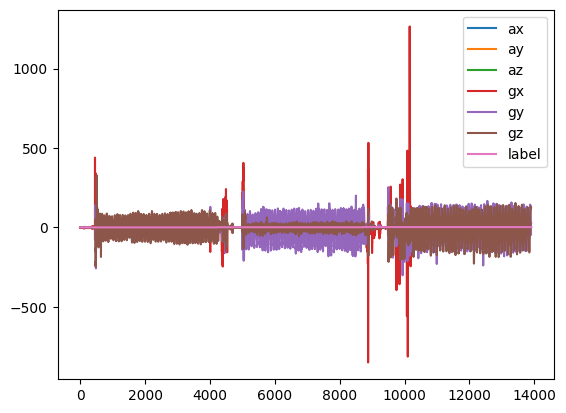

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('imu-3.csv')

# Dictionary to store offset and scale for each feature column
feature_info = {}

# Iterate through each column (excluding 'label' and 'label_name')
col_number = 1
for col_name in df.columns:
    if col_name not in ['label', 'label_name']:
        col_data = df[col_name]
        
        # Check for bad values (assuming bad values are represented as NaN)
        if col_data.isnull().values.any():
            # Handle missing values by filling them with appropriate values
            # For example, filling with the mean of the column
            df[col_name].fillna(df[col_name].mean(), inplace=True)
        
        max_val = col_data.max()
        min_val = col_data.min()
        scale = 1 / (max_val - min_val)
        offset = min_val
        feature_info[col_name] = {'offset': offset, 'scale': scale, 'number': col_number}
        col_number += 1

# Print offset and scale for each feature column
offsets = [feature_info[col]['offset'] for col in feature_info]
scales = [feature_info[col]['scale'] for col in feature_info]

columns_except_label = [col for col in df.columns if col not in ['label', 'label_name']]
num_columns = len(columns_except_label)
print("Number of columns except 'label' and 'label_name':", num_columns)

print("Offsets:", offsets)
print("Scales:", scales)

# Assign column numbers
column_numbers = {col: feature_info[col]['number'] for col in feature_info}
print("Column numbers:", column_numbers)

# Plot DataFrame
df.plot()


num_columns

<Axes: >

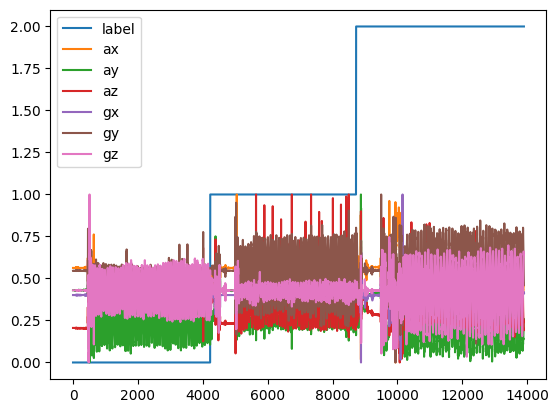

In [3]:
# Normalize every column in the DataFrame using offset and scale
normalized_df = pd.DataFrame({'label': df['label'], 'label_name': df['label_name']})
for col_name in df.columns:
    if col_name not in ['label', 'label_name']:
        offset = feature_info[col_name]['offset']
        scale = feature_info[col_name]['scale']
        normalized_df[col_name] = (df[col_name] - offset) * scale

normalized_df.plot()

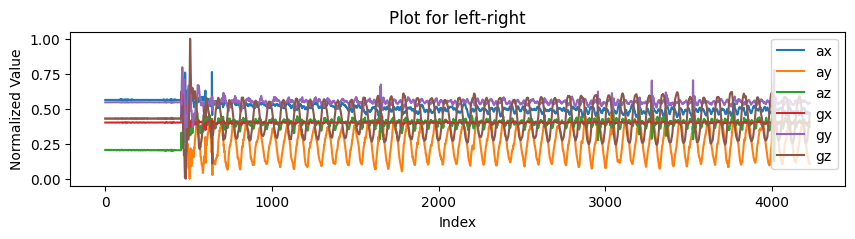

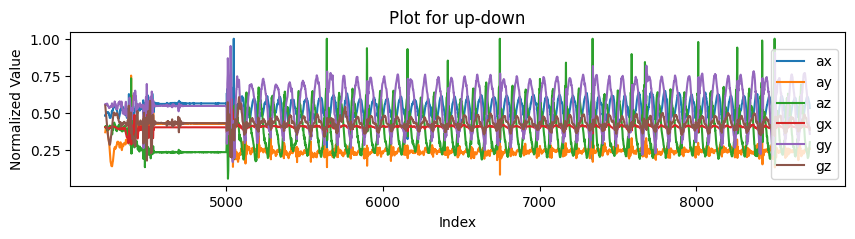

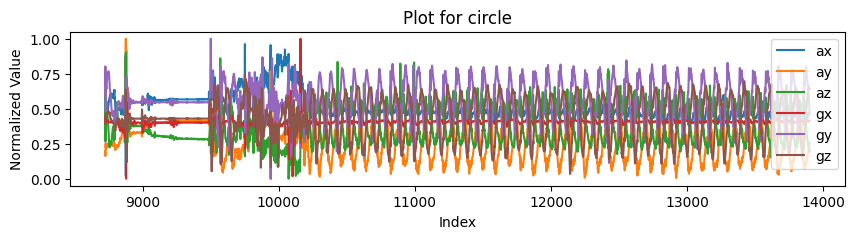

In [4]:
# Create a directory to save the plots if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Separate data into different DataFrames based on 'label_name' and plot each subset
unique_labels = normalized_df['label_name'].unique()
for label_name in unique_labels:
    subset_df = normalized_df[normalized_df['label_name'] == label_name]
    plt.figure(figsize=(10, 2))
    for col_name in subset_df.columns.drop(['label', 'label_name']):
        plt.plot(subset_df.index, subset_df[col_name], label=col_name)
    plt.title(f'Plot for {label_name}')
    plt.xlabel('Index')
    plt.ylabel('Normalized Value')
    plt.legend()

In [5]:
# Function to calculate features for a given window
def calculate_features(window):
    min_val = np.min(window)
    max_val = np.max(window)
    mean_val = np.mean(window)
    rms_val = np.sqrt(np.mean(window ** 2))
    return min_val, max_val, mean_val, rms_val

# Function to extract features from a dataframe
def extract_features(dataframe, window_length, hop_size):
    features_dict = {'label': [], 'label_name': []}
    # Iterate through each column (excluding 'label' and 'label_name')
    for col_name in dataframe.columns:
        if col_name not in ['label', 'label_name']:
            # Initialize keys for each column
            features_dict[f"{col_name}_min"] = []
            features_dict[f"{col_name}_max"] = []
            features_dict[f"{col_name}_mean"] = []
            features_dict[f"{col_name}_rms"] = []
            # Calculate features using rolling window approach
            for i in range(0, len(dataframe[col_name]) - window_length + 1, hop_size):
                window = dataframe[col_name].iloc[i:i + window_length]
                min_val, max_val, mean_val, rms_val = calculate_features(window)
                # Add values to features_dict with column-specific prefixes
                features_dict[f"{col_name}_min"].append(min_val)
                features_dict[f"{col_name}_max"].append(max_val)
                features_dict[f"{col_name}_mean"].append(mean_val)
                features_dict[f"{col_name}_rms"].append(rms_val)

    # Add label and label_name to features_dict
    features_dict['label'] = [dataframe['label'].iloc[0]] * len(features_dict[f"{col_name}_min"])  # Assuming label is the same for all rows in the dataframe
    features_dict['label_name'] = [dataframe['label_name'].iloc[0]] * len(features_dict[f"{col_name}_min"])  # Assuming label_name is the same for all rows in the dataframe
    
    # Create DataFrame from features_dict
    features_df = pd.DataFrame(features_dict)
    return features_df

#parameters
sampling_freq = 1000
mean_gesture_duration = 1000  
window_length = sampling_freq * mean_gesture_duration // 1000  
shift = 0.3
hop_size = int(shift * window_length)  # 0.3% of window length



buffer_length= num_columns * window_length
rem_length= buffer_length - (num_columns * hop_size)
shift_length= num_columns * hop_size
offsets_no_bracket = ", ".join(str(offset) for offsets in offsets)
scale_no_bracket = ", ".join(str(scales) for scales in scales)


# Separate data into different DataFrames based on 'label_name'
unique_labels = normalized_df['label_name'].unique()
features_dfs = []
for label_name in unique_labels:
    subset_df = normalized_df[normalized_df['label_name'] == label_name]
    features_df = extract_features(subset_df, window_length, hop_size)
    features_dfs.append(features_df)

# Concatenate features_dfs into a single features DataFrame
features_df = pd.concat(features_dfs, ignore_index=True)

# Print or further process features_df as needed
features_df.describe()

,label,ax_min,ax_max,ax_mean,ax_rms,ay_min,ay_max,ay_mean,ay_rms,az_min,...,gx_mean,gx_rms,gy_min,gy_max,gy_mean,gy_rms,gz_min,gz_max,gz_mean,gz_rms
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,1.081081,0.304574,0.682102,0.513741,0.516387,0.063284,0.532942,0.262577,0.279472,0.182500,...,0.404163,0.404776,0.238003,0.804805,0.547940,0.560107,0.185625,0.636910,0.428647,0.443375
std,0.829269,0.148897,0.162447,0.041543,0.043880,0.052151,0.159863,0.037749,0.038949,0.087426,...,0.003944,0.004243,0.160697,0.106925,0.004822,0.011051,0.117932,0.114895,0.003252,0.012114
min,0.000000,0.000000,0.534965,0.458654,0.460195,0.000000,0.307547,0.231183,0.236555,0.000000,...,0.399322,0.400293,0.000000,0.582902,0.540650,0.544831,0.000000,0.495662,0.418801,0.427473
25%,0.000000,0.227273,0.555944,0.484059,0.484839,0.015094,0.411321,0.238681,0.256746,0.169661,...,0.401073,0.401096,0.129196,0.759067,0.545294,0.546830,0.082093,0.581763,0.427067,0.431140
50%,1.000000,0.370629,0.629371,0.516385,0.519619,0.052830,0.560377,0.244555,0.267644,0.187625,...,0.401597,0.401859,0.216071,0.815926,0.546580,0.562274,0.198057,0.609301,0.429289,0.441654
75%,2.000000,0.433566,0.762238,0.529497,0.532497,0.086792,0.579245,0.267281,0.287568,0.213573,...,0.408255,0.409622,0.262139,0.845167,0.550329,0.567440,0.260645,0.672532,0.430496,0.450128
max,2.000000,0.454545,1.000000,0.630507,0.639630,0.167925,1.000000,0.368072,0.378286,0.341317,...,0.411172,0.412515,0.506045,1.000000,0.558927,0.577626,0.354381,1.000000,0.434563,0.468470


In [7]:
shuffled_df = features_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df

,label,label_name,ax_min,ax_max,ax_mean,ax_rms,ay_min,ay_max,ay_mean,ay_rms,...,gx_mean,gx_rms,gy_min,gy_max,gy_mean,gy_rms,gz_min,gz_max,gz_mean,gz_rms
0,1,up-down,0.227273,0.622378,0.516385,0.519660,0.081132,0.309434,0.238681,0.239244,...,0.401176,0.401289,0.247293,0.765012,0.544282,0.562728,0.332674,0.495662,0.428306,0.429268
1,1,up-down,0.234266,1.000000,0.529497,0.532497,0.132075,0.581132,0.275968,0.287568,...,0.405463,0.406144,0.166363,0.950851,0.544124,0.559911,0.198057,0.605483,0.429364,0.431280
2,0,left-right,0.433566,0.548951,0.499605,0.500029,0.052830,0.501887,0.242906,0.261498,...,0.400661,0.400675,0.487902,0.672966,0.545824,0.546115,0.256516,0.609301,0.428617,0.441654
3,2,circle,0.405594,0.566434,0.477479,0.478146,0.033962,0.579245,0.237619,0.266374,...,0.409452,0.409622,0.129196,0.820431,0.558927,0.577626,0.121274,0.672532,0.424415,0.455331
4,2,circle,0.363636,0.597902,0.459252,0.460853,0.005660,0.566038,0.231183,0.262027,...,0.410642,0.410765,0.112476,0.845167,0.557459,0.577520,0.105813,0.683967,0.428128,0.462836
5,2,circle,0.000000,0.961538,0.630507,0.639630,0.015094,0.769811,0.319777,0.340541,...,0.405124,0.410090,0.000000,1.000000,0.551087,0.563906,0.053271,0.746347,0.432290,0.448630
6,0,left-right,0.433566,0.545455,0.491559,0.491845,0.086792,0.432075,0.255638,0.272650,...,0.401073,0.401086,0.506045,0.582902,0.546664,0.546818,0.256516,0.608884,0.430384,0.444583
7,2,circle,0.000000,0.961538,0.605503,0.618292,0.015094,0.769811,0.291347,0.314826,...,0.403230,0.407959,0.000000,0.867706,0.542558,0.557762,0.078588,0.746347,0.429523,0.450128
8,2,circle,0.000000,0.961538,0.605738,0.611204,0.043396,0.769811,0.356683,0.370476,...,0.399322,0.400293,0.000000,1.000000,0.553969,0.562274,0.053271,0.746347,0.429245,0.441008
9,1,up-down,0.321678,0.629371,0.516566,0.519619,0.141509,0.309434,0.237732,0.238229,...,0.401597,0.401692,0.247293,0.759067,0.549079,0.567209,0.354381,0.539302,0.430051,0.431204


In [10]:
# Assuming shuffled_df contains the features DataFrame with the same order as mentioned
# Split features and labels
X = shuffled_df.drop(['label', 'label_name'], axis=1)
y = shuffled_df['label_name']
X.head()

,ax_min,ax_max,ax_mean,ax_rms,ay_min,ay_max,ay_mean,ay_rms,az_min,az_max,...,gx_mean,gx_rms,gy_min,gy_max,gy_mean,gy_rms,gz_min,gz_max,gz_mean,gz_rms
0,0.227273,0.622378,0.516385,0.519660,0.081132,0.309434,0.238681,0.239244,0.183633,1.000000,...,0.401176,0.401289,0.247293,0.765012,0.544282,0.562728,0.332674,0.495662,0.428306,0.429268
1,0.234266,1.000000,0.529497,0.532497,0.132075,0.581132,0.275968,0.287568,0.053892,1.000000,...,0.405463,0.406144,0.166363,0.950851,0.544124,0.559911,0.198057,0.605483,0.429364,0.431280
2,0.433566,0.548951,0.499605,0.500029,0.052830,0.501887,0.242906,0.261498,0.283433,0.528942,...,0.400661,0.400675,0.487902,0.672966,0.545824,0.546115,0.256516,0.609301,0.428617,0.441654
3,0.405594,0.566434,0.477479,0.478146,0.033962,0.579245,0.237619,0.266374,0.213573,0.830339,...,0.409452,0.409622,0.129196,0.820431,0.558927,0.577626,0.121274,0.672532,0.424415,0.455331
4,0.363636,0.597902,0.459252,0.460853,0.005660,0.566038,0.231183,0.262027,0.175649,0.782435,...,0.410642,0.410765,0.112476,0.845167,0.557459,0.577520,0.105813,0.683967,0.428128,0.462836


In [11]:
# Initialize Random Forest classifier for feature selection
rf_classifier_fs = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf= 1,
    min_samples_split= 2,
    random_state=42
)

sfs = SFS(rf_classifier_fs, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5)  # You can adjust the cv parameter as needed

sfs.fit(X, y)

d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instea

SequentialFeatureSelector(estimator=RandomForestClassifier(max_depth=10,
                                                           random_state=42),
                          k_features=(1, 24), scoring='accuracy')

In [12]:
# Get the selected features
selected_features = list(sfs.k_feature_names_)
print("Selected Features:", selected_features)

Selected Features: ['ax_min', 'ax_max']


In [13]:
# Reduce the dataset to the selected features
X_selected = X[selected_features]

In [14]:
# Initialize Random Forest classifier for cross-validation
rf_classifier_cv = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf= 1,
    min_samples_split= 2,
    random_state=42
)

In [15]:
# Stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [18]:
#!!!!!!!!!!!!!!!!!!!
accuracies = []
f1_scores = []
conf_matrices = []
all_y_true = []
all_y_pred = []

for train_index, test_index in kf.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier
    rf_classifier_cv.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier_cv.predict(X_test)
    
    # Collect the true and predicted labels
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    accuracies.append(accuracy)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)
    
    # Print accuracy for this fold
    print(f"Fold Accuracy: {accuracy:.10f}")

Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000
Fold Accuracy: 1.0000000000


In [19]:
# Calculate and print mean accuracy
mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy:.10f}")
print(f"Mean F1 Score: {mean_f1_score:.10f}")

Mean Accuracy: 1.0000000000
Mean F1 Score: 1.0000000000


In [20]:
# Aggregate confusion matrix
aggregate_conf_matrix = np.sum(conf_matrices, axis=0)

In [21]:
# Print metrics
print("Confusion Matrix:")
print(aggregate_conf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(all_y_true, all_y_pred))

Confusion Matrix:
[[14  0  0]
 [ 0 11  0]
 [ 0  0 12]]
Classification Report:
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00        14
  left-right       1.00      1.00      1.00        11
     up-down       1.00      1.00      1.00        12

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



Text(0.5, 1.0, 'Confusion Matrix')

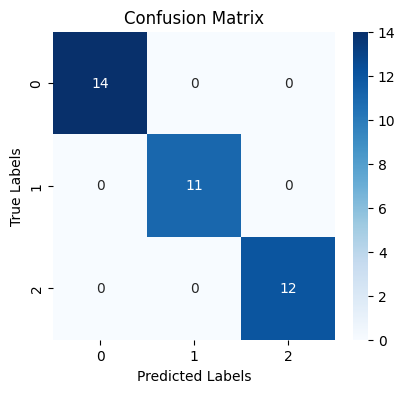

In [22]:
# Plot confusion matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(aggregate_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

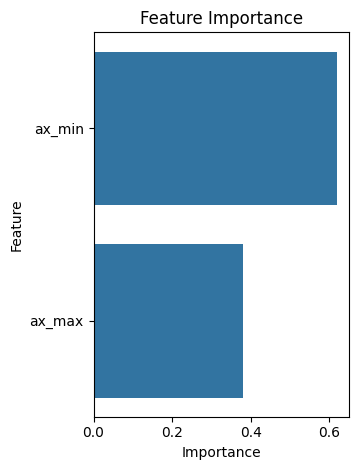

In [23]:
# Get feature importances from the final model trained on the full data
rf_classifier_cv.fit(X_selected, y)
feature_importances = rf_classifier_cv.feature_importances_

# Plot feature importance
plt.subplot(1, 2, 2)
feature_importance_df = pd.DataFrame({'Feature': X_selected.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.tight_layout()
plt.show()

In [24]:
print(rf_classifier_cv.predict([[-1, -1]]))

['circle']


d:\Python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
